# 镜像与猫鼠游戏——反卷积生成网络与DCGAN

本文件是集智AI学园开发的“火炬上的深度学习”系列课程第五节课：《镜像网络与猫鼠游戏》的配套文档。在本文档中，我们实现了一个反卷积神经网络生成器，它可以通过输入的信号，生成一张逼真的手写数字图像。为了让我们的生成图像能够足够逼真，我们尝试了三种不同的方法：

1、在MINST数据集中，选出一个样本，输入数字标签，输出图像，并让输出的图像与样本图像尽可能相似，总误差最小化；
2、同上，只不过并不直接比较输出和样本相似性，而是让一个已训练好的手写数字识别网络来判断这个伪造的图像是几；
3、DCGAN，同时训练一个生成器一个判别器。每个时刻随机采样一个向量输入给生成器，它输出一张图像，同时读取一个数据样本，判别器判断样本图像
和生成图像的真假。

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第V课的配套源代码




In [105]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好.
# 在Windows需要单独安装torchvision包，在命令行运行pip install torchvision即可
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutil


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [106]:
# 定义超参数
image_size = 28 #图像尺寸大小
input_dim = 100 #输入给生成器的向量维度，维度越大可以增加生成器输出样本的多样性
num_channels = 1# 图像的通道数
num_features = 64 #生成器中间的卷积核数量
batch_size = 64 #批次大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor，在加载数据的时候，就可以对图像做预处理
                            download=True) #当找不到文件的时候，自动下载

# 加载测试数据集
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

'''我们希望将测试数据分成两部分，一部分作为校验数据，一部分作为测试数据。
校验数据用于检测模型是否过拟合，并调整参数，测试数据检验整个模型的工作'''


# 首先，我们定义下标数组indices，它相当于对所有test_dataset中数据的编码
# 然后定义下标indices_val来表示校验集数据的那些下标，indices_test表示测试集的下标
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据两个采样器来定义加载器，注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )


## 一、生成器预测图像模型

在这个模型中，我们根据输入的手写数字生成一张图像，并让这个图像与数据中的样本图像尽可能一致

In [143]:
#生成器模型定义

class ModelG(nn.Module):
    def __init__(self):
        super(ModelG,self).__init__()
        self.model=nn.Sequential() #model为一个内嵌的序列化的神经网络模型
        
        # 利用add_module增加一个反卷积层，输入为input_dim维，输出为2*num_features维，窗口大小为5，padding是0
        # 输入图像大小为1，输出图像大小为W'=(W-1)S-2P+K+P'=(1-1)*2-2*0+5+0=3, 5*5
        self.model.add_module('deconv1',nn.ConvTranspose2d(input_dim, num_features*2, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm1',nn.BatchNorm2d(num_features*2))
        # 增加非线性层
        self.model.add_module('relu1',nn.ReLU(True))
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口5，padding=0
        # 输入图像大小为5，输出图像大小为W'=(W-1)S-2P+K+P'=(5-1)*2-2*0+5+0=13, 13*13
        self.model.add_module('deconv2',nn.ConvTranspose2d(num_features*2, num_features, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm2',nn.BatchNorm2d(num_features))
        # 增加非线性层
        self.model.add_module('relu2',nn.ReLU(True))

        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口4，padding=0
        # 输入图像大小为13，输出图像大小为W'=(W-1)S-2P+K+P'=(13-1)*2-2*0+4+0=28, 28*28
        self.model.add_module('deconv3',nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0,bias=False))
        #self.model.add_module('tanh',nn.Tanh())
        self.model.add_module('sigmoid',nn.Sigmoid())
    def forward(self,input):
        output = input
        
        #遍历网络的所有层，一层层输出信息
        for name, module in self.model.named_children():
            output = module(output)
        #输出一张28*28的图像
        return(output)


def weight_init(m):
    #模型参数初始化．
    #默认的初始化参数卷积核的权重是均值大概为0，方差在10^{-2}. BatchNorm层的权重均值是大约0.5，方差在0.2左右
    #使用如下初始化方式可以，可以让方差更小，使得收敛更快
    class_name=m.__class__.__name__
    if class_name.find('conv')!=-1:
        m.weight.data.normal_(0,0.02)
    if class_name.find('norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
def make_show(img):
    # 将张量变成可以显示的图像
    img = img.data.expand(batch_size, 3, image_size, image_size)
    return img
def imshow(inp, title=None, ax=None):
    # 在屏幕上绘制图像
    """Imshow for Tensor."""
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue)/(maxvalue - mvalue)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)


In [ ]:

#训练模型

print('Initialized!')

#定义生成器模型
net = ModelG()
net = net.cuda() if use_cuda else net

#目标函数采用最小均方误差
criterion = nn.MSELoss()
#定义优化器
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

# 随机选择生成0-9的数字，用于每个周期打印查看结果用
samples = np.random.choice(10, batch_size) 
samples = Variable(torch.from_numpy(samples).type(dtype))
#开始训练
step = 0 #计数经历了多少时间步
num_epochs = 100 #总的训练周期
record = []
for epoch in range(num_epochs):
    train_loss = []
    
    # 加载数据批次
    for batch_idx, (data, target) in enumerate(train_loader):
        # 注意数据中的data转化为了要预测的target，数据中的target则转化成了输入给网络的标签
        target, data = Variable(data), Variable(target) #将Tensor转化为Variable，data为一批图像，target为一批标签
        # 将数据加载到GPU中
        if use_cuda:
            target, data = target.cuda(), data.cuda()
        #将输入的数字标签转化为生成器net能够接受的(batch_size, input_dim, 1, 1)维张量
        data = data.type(dtype)
        data = data.resize(data.size()[0], 1, 1, 1)
        data = data.expand(data.size()[0], input_dim, 1, 1)

        net.train() # 给网络模型做标记，标志说模型正在训练集上训练，
                    #这种区分主要是为了打开关闭net的training标志
        output = net(data) #神经网络完成一次前馈的计算过程，得到预测输出output
        loss = criterion(output, target) #将output与标签target比较，计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降算法
        step += 1
        # 记载损失函数值
        if use_cuda:
            loss = loss.cpu()
        train_loss.append(loss.data.numpy()[0])
        
        
        if step % 100 == 0: #每间隔100个batch执行一次打印等操作    
            net.eval() # 给网络模型做标记，标志说模型在校验集上运行
            val_loss = [] #记录校验数据集准确率的容器
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            idx = 0
            for (data, target) in validation_loader:
                target, data = Variable(data), Variable(target)
                idx += 1
                if use_cuda:
                    target, data = target.cuda(), data.cuda()
                data = data.type(dtype)
                data = data.resize(data.size()[0], 1, 1, 1)
                data = data.expand(data.size()[0], input_dim, 1, 1)
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                loss = criterion(output, target) #将output与标签target比较，计算误差
                if use_cuda:
                    loss = loss.cpu()
                val_loss.append(loss.data.numpy()[0])
                #打印误差等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print('训练周期: {} [{}/{} ({:.0f}%)]\t训练数据Loss: {:.6f}\t校验数据Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(train_loss), np.mean(val_loss)))
            record.append([np.mean(train_loss), np.mean(val_loss)])
        
    
    # 产生一组图像保存到temp1文件夹下（需要事先建立好该文件夹），检测生成器当前的效果
    # 改变输入数字的尺寸，适应于生成器网络
    samples.data.resize_(batch_size,1,1,1)
    samples = Variable(samples.data.expand(batch_size, input_dim, 1, 1))
    samples = samples.cuda() if use_cuda else samples #加载到GPU
    fake_u=net(samples) #用原始网络作为输入，得到伪造的图像数据
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u) #将张量转化成可绘制的图像
    vutil.save_image(img,'temp1/fake%s.png'% (epoch)) #保存生成的图像
        

Initialized!
训练周期: 0 [6336/60000 (11%)]	训练数据Loss: 0.231903	校验数据Loss: 0.230012
训练周期: 0 [12736/60000 (21%)]	训练数据Loss: 0.229758	校验数据Loss: 0.225729
训练周期: 0 [19136/60000 (32%)]	训练数据Loss: 0.227703	校验数据Loss: 0.221447
训练周期: 0 [25536/60000 (43%)]	训练数据Loss: 0.225683	校验数据Loss: 0.217530
训练周期: 0 [31936/60000 (53%)]	训练数据Loss: 0.223683	校验数据Loss: 0.213548
训练周期: 0 [38336/60000 (64%)]	训练数据Loss: 0.221714	校验数据Loss: 0.209791
训练周期: 0 [44736/60000 (75%)]	训练数据Loss: 0.219773	校验数据Loss: 0.206013
训练周期: 0 [51136/60000 (85%)]	训练数据Loss: 0.217828	校验数据Loss: 0.202227
训练周期: 0 [57536/60000 (96%)]	训练数据Loss: 0.215902	校验数据Loss: 0.198174
训练周期: 1 [3904/60000 (7%)]	训练数据Loss: 0.195607	校验数据Loss: 0.194209
训练周期: 1 [10304/60000 (17%)]	训练数据Loss: 0.193718	校验数据Loss: 0.189963
训练周期: 1 [16704/60000 (28%)]	训练数据Loss: 0.191835	校验数据Loss: 0.185890
训练周期: 1 [23104/60000 (38%)]	训练数据Loss: 0.189895	校验数据Loss: 0.181830
训练周期: 1 [29504/60000 (49%)]	训练数据Loss: 0.187900	校验数据Loss: 0.177686
训练周期: 1 [35904/60000 (60%)]	训练数据Loss: 0.185893	校验数据Loss: 0.173639


训练周期: 13 [19520/60000 (33%)]	训练数据Loss: 0.072273	校验数据Loss: 0.069569
训练周期: 13 [25920/60000 (43%)]	训练数据Loss: 0.072276	校验数据Loss: 0.069561
训练周期: 13 [32320/60000 (54%)]	训练数据Loss: 0.072254	校验数据Loss: 0.069485
训练周期: 13 [38720/60000 (64%)]	训练数据Loss: 0.072166	校验数据Loss: 0.069268
训练周期: 13 [45120/60000 (75%)]	训练数据Loss: 0.072120	校验数据Loss: 0.069138
训练周期: 13 [51520/60000 (86%)]	训练数据Loss: 0.072164	校验数据Loss: 0.069096
训练周期: 13 [57920/60000 (96%)]	训练数据Loss: 0.072098	校验数据Loss: 0.068987
训练周期: 14 [4288/60000 (7%)]	训练数据Loss: 0.071917	校验数据Loss: 0.068962
训练周期: 14 [10688/60000 (18%)]	训练数据Loss: 0.071622	校验数据Loss: 0.068828
训练周期: 14 [17088/60000 (28%)]	训练数据Loss: 0.071710	校验数据Loss: 0.068753
训练周期: 14 [23488/60000 (39%)]	训练数据Loss: 0.071566	校验数据Loss: 0.068675
训练周期: 14 [29888/60000 (50%)]	训练数据Loss: 0.071511	校验数据Loss: 0.068618
训练周期: 14 [36288/60000 (60%)]	训练数据Loss: 0.071443	校验数据Loss: 0.068562
训练周期: 14 [42688/60000 (71%)]	训练数据Loss: 0.071447	校验数据Loss: 0.068591
训练周期: 14 [49088/60000 (82%)]	训练数据Loss: 0.071442	校验数据Loss: 0.0684

训练周期: 26 [26304/60000 (44%)]	训练数据Loss: 0.067402	校验数据Loss: 0.064447
训练周期: 26 [32704/60000 (54%)]	训练数据Loss: 0.067317	校验数据Loss: 0.064511
训练周期: 26 [39104/60000 (65%)]	训练数据Loss: 0.067348	校验数据Loss: 0.064505
训练周期: 26 [45504/60000 (76%)]	训练数据Loss: 0.067343	校验数据Loss: 0.064496
训练周期: 26 [51904/60000 (86%)]	训练数据Loss: 0.067368	校验数据Loss: 0.064444
训练周期: 26 [58304/60000 (97%)]	训练数据Loss: 0.067368	校验数据Loss: 0.064415
训练周期: 27 [4672/60000 (8%)]	训练数据Loss: 0.067003	校验数据Loss: 0.064425
训练周期: 27 [11072/60000 (18%)]	训练数据Loss: 0.066963	校验数据Loss: 0.064326
训练周期: 27 [17472/60000 (29%)]	训练数据Loss: 0.067135	校验数据Loss: 0.064397
训练周期: 27 [23872/60000 (40%)]	训练数据Loss: 0.067258	校验数据Loss: 0.064297
训练周期: 27 [30272/60000 (50%)]	训练数据Loss: 0.067170	校验数据Loss: 0.064506
训练周期: 27 [36672/60000 (61%)]	训练数据Loss: 0.067128	校验数据Loss: 0.064337
训练周期: 27 [43072/60000 (72%)]	训练数据Loss: 0.067199	校验数据Loss: 0.064352
训练周期: 27 [49472/60000 (82%)]	训练数据Loss: 0.067208	校验数据Loss: 0.064316
训练周期: 27 [55872/60000 (93%)]	训练数据Loss: 0.067181	校验数据Loss: 0.0643

训练周期: 39 [33088/60000 (55%)]	训练数据Loss: 0.065853	校验数据Loss: 0.063075
训练周期: 39 [39488/60000 (66%)]	训练数据Loss: 0.065807	校验数据Loss: 0.062819
训练周期: 39 [45888/60000 (76%)]	训练数据Loss: 0.065807	校验数据Loss: 0.062936
训练周期: 39 [52288/60000 (87%)]	训练数据Loss: 0.065806	校验数据Loss: 0.062889
训练周期: 39 [58688/60000 (98%)]	训练数据Loss: 0.065855	校验数据Loss: 0.062932
训练周期: 40 [5056/60000 (8%)]	训练数据Loss: 0.065919	校验数据Loss: 0.062830
训练周期: 40 [11456/60000 (19%)]	训练数据Loss: 0.065918	校验数据Loss: 0.062886
训练周期: 40 [17856/60000 (30%)]	训练数据Loss: 0.066027	校验数据Loss: 0.063028
训练周期: 40 [24256/60000 (40%)]	训练数据Loss: 0.065943	校验数据Loss: 0.062803
训练周期: 40 [30656/60000 (51%)]	训练数据Loss: 0.066023	校验数据Loss: 0.062841
训练周期: 40 [37056/60000 (62%)]	训练数据Loss: 0.065963	校验数据Loss: 0.062781
训练周期: 40 [43456/60000 (72%)]	训练数据Loss: 0.065946	校验数据Loss: 0.062844
训练周期: 40 [49856/60000 (83%)]	训练数据Loss: 0.065887	校验数据Loss: 0.062881
训练周期: 40 [56256/60000 (94%)]	训练数据Loss: 0.065813	校验数据Loss: 0.062841
训练周期: 41 [2624/60000 (4%)]	训练数据Loss: 0.065564	校验数据Loss: 0.062888

训练周期: 52 [39872/60000 (66%)]	训练数据Loss: 0.065131	校验数据Loss: 0.062026
训练周期: 52 [46272/60000 (77%)]	训练数据Loss: 0.065130	校验数据Loss: 0.062148
训练周期: 52 [52672/60000 (88%)]	训练数据Loss: 0.065096	校验数据Loss: 0.062166
训练周期: 52 [59072/60000 (98%)]	训练数据Loss: 0.065040	校验数据Loss: 0.062070
训练周期: 53 [5440/60000 (9%)]	训练数据Loss: 0.065156	校验数据Loss: 0.062129
训练周期: 53 [11840/60000 (20%)]	训练数据Loss: 0.065144	校验数据Loss: 0.062128
训练周期: 53 [18240/60000 (30%)]	训练数据Loss: 0.065061	校验数据Loss: 0.062015
训练周期: 53 [24640/60000 (41%)]	训练数据Loss: 0.065034	校验数据Loss: 0.062134
训练周期: 53 [31040/60000 (52%)]	训练数据Loss: 0.064948	校验数据Loss: 0.061944
训练周期: 53 [37440/60000 (62%)]	训练数据Loss: 0.064965	校验数据Loss: 0.062050
训练周期: 53 [43840/60000 (73%)]	训练数据Loss: 0.064980	校验数据Loss: 0.062041
训练周期: 53 [50240/60000 (84%)]	训练数据Loss: 0.065017	校验数据Loss: 0.062239
训练周期: 53 [56640/60000 (94%)]	训练数据Loss: 0.065008	校验数据Loss: 0.062066
训练周期: 54 [3008/60000 (5%)]	训练数据Loss: 0.065631	校验数据Loss: 0.062167
训练周期: 54 [9408/60000 (16%)]	训练数据Loss: 0.065323	校验数据Loss: 0.062216


训练周期: 65 [46656/60000 (78%)]	训练数据Loss: 0.064478	校验数据Loss: 0.061706
训练周期: 65 [53056/60000 (88%)]	训练数据Loss: 0.064514	校验数据Loss: 0.061627
训练周期: 65 [59456/60000 (99%)]	训练数据Loss: 0.064514	校验数据Loss: 0.061553
训练周期: 66 [5824/60000 (10%)]	训练数据Loss: 0.064119	校验数据Loss: 0.061566
训练周期: 66 [12224/60000 (20%)]	训练数据Loss: 0.064216	校验数据Loss: 0.061621
训练周期: 66 [18624/60000 (31%)]	训练数据Loss: 0.064223	校验数据Loss: 0.061584
训练周期: 66 [25024/60000 (42%)]	训练数据Loss: 0.064350	校验数据Loss: 0.061502
训练周期: 66 [31424/60000 (52%)]	训练数据Loss: 0.064402	校验数据Loss: 0.061624
训练周期: 66 [37824/60000 (63%)]	训练数据Loss: 0.064357	校验数据Loss: 0.061599
训练周期: 66 [44224/60000 (74%)]	训练数据Loss: 0.064412	校验数据Loss: 0.061512
训练周期: 66 [50624/60000 (84%)]	训练数据Loss: 0.064433	校验数据Loss: 0.061388
训练周期: 66 [57024/60000 (95%)]	训练数据Loss: 0.064458	校验数据Loss: 0.061546
训练周期: 67 [3392/60000 (6%)]	训练数据Loss: 0.064395	校验数据Loss: 0.061466
训练周期: 67 [9792/60000 (16%)]	训练数据Loss: 0.064661	校验数据Loss: 0.061558
训练周期: 67 [16192/60000 (27%)]	训练数据Loss: 0.064538	校验数据Loss: 0.061493

训练周期: 78 [53440/60000 (89%)]	训练数据Loss: 0.064120	校验数据Loss: 0.061285
训练周期: 78 [59840/60000 (100%)]	训练数据Loss: 0.064116	校验数据Loss: 0.061127
训练周期: 79 [6208/60000 (10%)]	训练数据Loss: 0.064076	校验数据Loss: 0.061207
训练周期: 79 [12608/60000 (21%)]	训练数据Loss: 0.064048	校验数据Loss: 0.061268
训练周期: 79 [19008/60000 (32%)]	训练数据Loss: 0.064067	校验数据Loss: 0.061220
训练周期: 79 [25408/60000 (42%)]	训练数据Loss: 0.064131	校验数据Loss: 0.061136
训练周期: 79 [31808/60000 (53%)]	训练数据Loss: 0.064054	校验数据Loss: 0.061199
训练周期: 79 [38208/60000 (64%)]	训练数据Loss: 0.064058	校验数据Loss: 0.061226
训练周期: 79 [44608/60000 (74%)]	训练数据Loss: 0.064040	校验数据Loss: 0.061234
训练周期: 79 [51008/60000 (85%)]	训练数据Loss: 0.064060	校验数据Loss: 0.061170
训练周期: 79 [57408/60000 (96%)]	训练数据Loss: 0.064074	校验数据Loss: 0.061085
训练周期: 80 [3776/60000 (6%)]	训练数据Loss: 0.064039	校验数据Loss: 0.061061
训练周期: 80 [10176/60000 (17%)]	训练数据Loss: 0.064134	校验数据Loss: 0.061209
训练周期: 80 [16576/60000 (28%)]	训练数据Loss: 0.064090	校验数据Loss: 0.061169
训练周期: 80 [22976/60000 (38%)]	训练数据Loss: 0.064042	校验数据Loss: 0.0610

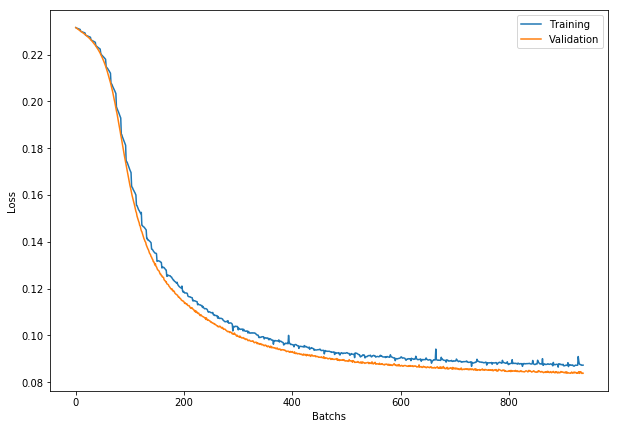

In [110]:
plt.figure(figsize = (10, 7))
plt.plot([i[0] for i in record], label='Training')
plt.plot([i[1] for i in record], label='Validation')
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.legend()

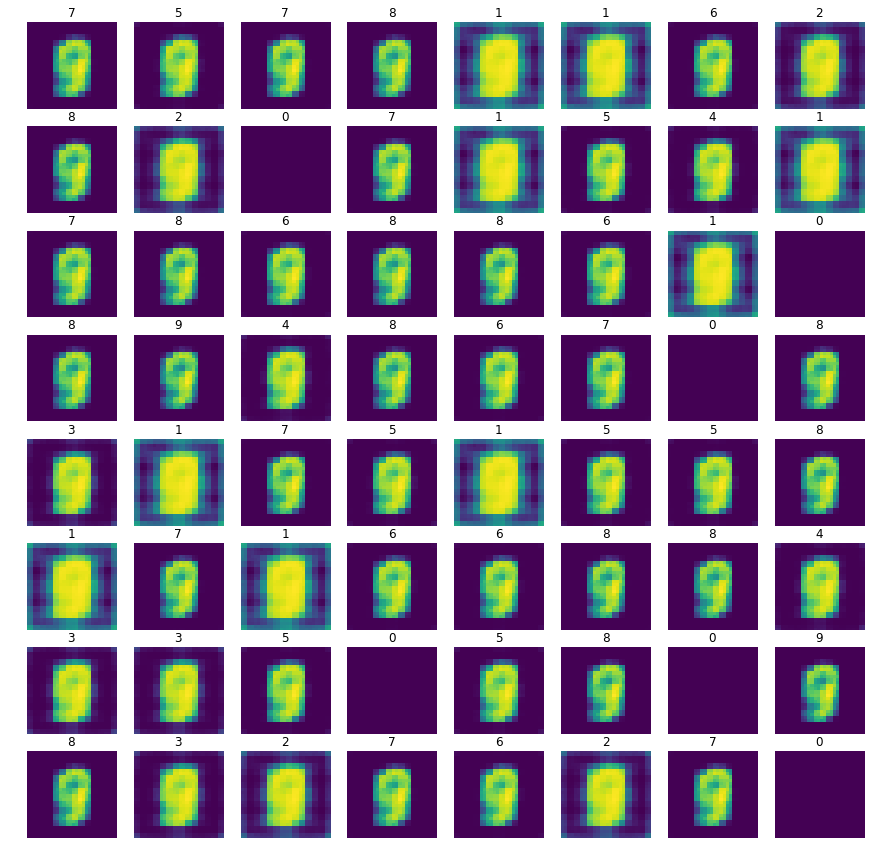

In [111]:
# 绘制一批图像样本
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u.data #将张量转化成可绘制的图像
fig = plt.figure(figsize = (15, 15))
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(8,8, sharex=True, figsize=(15,15))
for i in range(batch_size):
    
    axarr[i // 8, i % 8].axis('off')
    imshow(img[i], samples.data.numpy()[i][0,0,0].astype(int),axarr[i // 8, i % 8])

## 二、生成器 － 识别器模型

在这个模型中，我们不改变生成器，但是改变了网络的目标函数。我们加入了一个识别器，它通过固定值的方式迁移自一个手写体识别器
然后让生成器生成图像，并让识别器进行识别，将识别的误差作为目标函数，调整生成器，从而能给出正确的分类标签

In [112]:
# 定义待迁移的网络框架，所有的神经网络模块包括：Conv2d、MaxPool2d，Linear等模块都不需要重新定义，会自动加载
# 但是网络的forward功能没有办法自动实现，需要重写。
# 一般的，加载网络只加载网络的属性，不加载方法
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x) #log_softmax可以理解为概率对数值
        return x
    def retrieve_features(self, x):
        #该函数专门用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素


In [113]:
netR = torch.load('minst_conv_checkpoint') #读取硬盘上的minst_conv_checkpoint文件
netR = netR.cuda() if use_cuda else netR #加载到GPU中
for para in netR.parameters():
    para.requires_grad = False #将识别器的权重设置为固定值

/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can re

In [159]:
#开始训练

print('Initialized!')

netG = ModelG() #新建一个生成器
netG = netG.cuda() if use_cuda else netG #加载到GPU上
netG.apply(weight_init) #初始化参数

criterion = nn.CrossEntropyLoss() #用交叉熵作为损失函数
optimizer = optim.SGD(netG.parameters(), lr=0.0001, momentum=0.9) #定义优化器

#随机选择batch_size个数字，用他们来生成数字图像
samples = np.random.choice(10, batch_size)
samples = Variable(torch.from_numpy(samples).type(dtype))

num_epochs = 100 #总训练周期
statistics = [] #数据记载器
for epoch in range(num_epochs):
    train_loss = []
    train_rights = []
    
    # 加载数据
    for batch_idx, (data, target) in enumerate(train_loader):
        # 注意图像和标签互换了
        target, data = Variable(data), Variable(target) #将Tensor转化为Variable，data为一批标签，target为一批图像
        if use_cuda:
            target, data = target.cuda(), data.cuda()
        # 复制标签变量放到了label中
        label = data.clone()
        data = data.type(dtype)
        # 改变张量形状以适用于生成器网络
        data = data.resize(data.size()[0], 1, 1, 1)
        data = data.expand(data.size()[0], input_dim, 1, 1)

        netG.train() # 给网络模型做标记，标志说模型正在训练集上训练，
        netR.train() #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
        output1 = netG(data) #神经网络完成一次前馈的计算过程，得到预测输出output
        output = netR(output1) #用识别器网络来做分类
        loss = criterion(output, label) #将output与标签target比较，计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降算法
        step += 1
        if use_cuda:
            loss = loss.cpu()
        train_loss.append(loss.data.numpy()[0])
        right = rightness(output, label) #计算准确率所需数值，返回数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器train_rights中
        
        if step % 100 == 0: #每间隔100个batch执行一次打印等操作
            
            netG.eval() # 给网络模型做标记，标志说模型正在校验集上运行，
            netR.eval() #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
            val_loss = [] #记录校验数据集准确率的容器
            val_rights = []
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                # 注意target是图像，data是标签
                target, data = Variable(data), Variable(target)
                if use_cuda:
                    target, data = target.cuda(), data.cuda()
                label = data.clone()
                data = data.type(dtype)
                #改变Tensor大小以适应生成网络
                data = data.resize(data.size()[0], 1, 1, 1)
                data = data.expand(data.size()[0], input_dim, 1, 1)
                
                output1 = netG(data) #神经网络完成一次前馈的计算过程，得到预测输出output
                output = netR(output1) #利用识别器来识别
                loss = criterion(output, label) #将output与标签target比较，计算误差
                if use_cuda:
                    loss = loss.cpu()
                val_loss.append(loss.data.numpy()[0])
                right = rightness(output, label) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)
            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            #train_r为一个二元组，分别记录目前已经经历过的所有训练集中分类正确的数量和该集合中总的样本数，
            #train_r[0]/train_r[1]就是训练集的分类准确度，同样，val_r[0]/val_r[1]就是校验集上的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            print(('训练周期: {} [{}/{} ({:.0f}%)]\t训练数据Loss: {:.6f},正确率: {:.2f}%\t校验数据Loss:' +
                  '{:.6f},正确率:{:.2f}%').format(epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(train_loss), 
                                               100. * train_r[0] / train_r[1], 
                                               np.mean(val_loss), 
                                               100. * val_r[0] / val_r[1]))
            #记录中间的数据
            statistics.append({'loss':np.mean(train_loss),'train': 100. * train_r[0] / train_r[1],
                               'valid':100. * val_r[0] / val_r[1]})
            
    # 产生一组图像保存到temp1文件夹下（需要事先建立好该文件夹），检测生成器当前的效果
    samples.data.resize_(batch_size,1,1,1)
    samples = Variable(samples.data.expand(batch_size, input_dim, 1, 1))
    samples = samples.cuda() if use_cuda else inputs
    fake_u=netG(samples)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)
    vutil.save_image(img,'temp1/fake%s.png'% (epoch))

Initialized!


/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


训练周期: 0 [6336/60000 (11%)]	训练数据Loss: 3.714461,正确率: 7.62%	校验数据Loss:2.729017,正确率:9.78%
训练周期: 0 [12736/60000 (21%)]	训练数据Loss: 3.001835,正确率: 14.77%	校验数据Loss:1.491780,正确率:41.80%
训练周期: 0 [19136/60000 (32%)]	训练数据Loss: 2.531274,正确率: 23.60%	校验数据Loss:1.130692,正确率:70.74%
训练周期: 0 [25536/60000 (43%)]	训练数据Loss: 2.220710,正确率: 31.05%	校验数据Loss:0.958856,正确率:61.62%
训练周期: 0 [31936/60000 (53%)]	训练数据Loss: 2.013786,正确率: 36.32%	校验数据Loss:0.895255,正确率:79.36%
训练周期: 0 [38336/60000 (64%)]	训练数据Loss: 1.848340,正确率: 40.80%	校验数据Loss:0.742793,正确率:61.62%
训练周期: 0 [44736/60000 (75%)]	训练数据Loss: 1.723661,正确率: 44.17%	校验数据Loss:0.586364,正确率:90.22%
训练周期: 0 [51136/60000 (85%)]	训练数据Loss: 1.620259,正确率: 47.01%	校验数据Loss:0.559427,正确率:90.22%
训练周期: 0 [57536/60000 (96%)]	训练数据Loss: 1.533888,正确率: 49.47%	校验数据Loss:0.468020,正确率:100.00%
训练周期: 1 [3904/60000 (7%)]	训练数据Loss: 0.808619,正确率: 70.39%	校验数据Loss:0.535289,正确率:100.00%
训练周期: 1 [10304/60000 (17%)]	训练数据Loss: 0.744449,正确率: 72.94%	校验数据Loss:0.479593,正确率:70.74%
训练周期: 1 [16704/60000 (28%)]	训练数据Los

训练周期: 10 [1216/60000 (2%)]	训练数据Loss: 0.211509,正确率: 91.80%	校验数据Loss:0.045253,正确率:100.00%
训练周期: 10 [7616/60000 (13%)]	训练数据Loss: 0.208643,正确率: 92.89%	校验数据Loss:0.061754,正确率:100.00%
训练周期: 10 [14016/60000 (23%)]	训练数据Loss: 0.240151,正确率: 92.10%	校验数据Loss:0.048868,正确率:100.00%
训练周期: 10 [20416/60000 (34%)]	训练数据Loss: 0.238893,正确率: 92.25%	校验数据Loss:0.038400,正确率:100.00%
训练周期: 10 [26816/60000 (45%)]	训练数据Loss: 0.239530,正确率: 92.11%	校验数据Loss:0.054387,正确率:100.00%
训练周期: 10 [33216/60000 (55%)]	训练数据Loss: 0.255546,正确率: 91.37%	校验数据Loss:0.127453,正确率:100.00%
训练周期: 10 [39616/60000 (66%)]	训练数据Loss: 0.248090,正确率: 91.63%	校验数据Loss:0.042013,正确率:100.00%
训练周期: 10 [46016/60000 (77%)]	训练数据Loss: 0.248541,正确率: 91.63%	校验数据Loss:0.022901,正确率:100.00%
训练周期: 10 [52416/60000 (87%)]	训练数据Loss: 0.245371,正确率: 91.75%	校验数据Loss:0.070020,正确率:100.00%
训练周期: 10 [58816/60000 (98%)]	训练数据Loss: 0.240783,正确率: 91.90%	校验数据Loss:0.020083,正确率:100.00%
训练周期: 11 [5184/60000 (9%)]	训练数据Loss: 0.202320,正确率: 93.73%	校验数据Loss:0.045100,正确率:100.00%
训练周期: 11 [11584

训练周期: 19 [49728/60000 (83%)]	训练数据Loss: 0.128748,正确率: 95.97%	校验数据Loss:0.014693,正确率:100.00%
训练周期: 19 [56128/60000 (93%)]	训练数据Loss: 0.128997,正确率: 95.99%	校验数据Loss:0.012006,正确率:100.00%
训练周期: 20 [2496/60000 (4%)]	训练数据Loss: 0.076944,正确率: 98.24%	校验数据Loss:0.007037,正确率:100.00%
训练周期: 20 [8896/60000 (15%)]	训练数据Loss: 0.077895,正确率: 98.31%	校验数据Loss:0.006105,正确率:100.00%
训练周期: 20 [15296/60000 (25%)]	训练数据Loss: 0.098615,正确率: 97.40%	校验数据Loss:0.008064,正确率:100.00%
训练周期: 20 [21696/60000 (36%)]	训练数据Loss: 0.117579,正确率: 96.85%	校验数据Loss:0.013812,正确率:100.00%
训练周期: 20 [28096/60000 (47%)]	训练数据Loss: 0.124850,正确率: 96.67%	校验数据Loss:0.016119,正确率:100.00%
训练周期: 20 [34496/60000 (57%)]	训练数据Loss: 0.129912,正确率: 96.44%	校验数据Loss:0.021590,正确率:100.00%
训练周期: 20 [40896/60000 (68%)]	训练数据Loss: 0.129879,正确率: 96.48%	校验数据Loss:0.009000,正确率:100.00%
训练周期: 20 [47296/60000 (79%)]	训练数据Loss: 0.127367,正确率: 96.51%	校验数据Loss:0.010234,正确率:100.00%
训练周期: 20 [53696/60000 (89%)]	训练数据Loss: 0.125306,正确率: 96.59%	校验数据Loss:0.012045,正确率:100.00%
训练周期: 21 [64/

训练周期: 29 [38208/60000 (64%)]	训练数据Loss: 0.073746,正确率: 98.04%	校验数据Loss:0.002951,正确率:100.00%
训练周期: 29 [44608/60000 (74%)]	训练数据Loss: 0.079526,正确率: 97.87%	校验数据Loss:0.003806,正确率:100.00%
训练周期: 29 [51008/60000 (85%)]	训练数据Loss: 0.074824,正确率: 98.04%	校验数据Loss:0.004862,正确率:100.00%
训练周期: 29 [57408/60000 (96%)]	训练数据Loss: 0.072522,正确率: 98.09%	校验数据Loss:0.004464,正确率:100.00%
训练周期: 30 [3776/60000 (6%)]	训练数据Loss: 0.084577,正确率: 97.97%	校验数据Loss:0.006012,正确率:100.00%
训练周期: 30 [10176/60000 (17%)]	训练数据Loss: 0.069763,正确率: 98.20%	校验数据Loss:0.003351,正确率:100.00%
训练周期: 30 [16576/60000 (28%)]	训练数据Loss: 0.066688,正确率: 98.20%	校验数据Loss:0.003042,正确率:100.00%
训练周期: 30 [22976/60000 (38%)]	训练数据Loss: 0.079688,正确率: 97.80%	校验数据Loss:0.034744,正确率:100.00%
训练周期: 30 [29376/60000 (49%)]	训练数据Loss: 0.078448,正确率: 97.85%	校验数据Loss:0.005349,正确率:100.00%
训练周期: 30 [35776/60000 (60%)]	训练数据Loss: 0.077387,正确率: 97.94%	校验数据Loss:0.003309,正确率:100.00%
训练周期: 30 [42176/60000 (70%)]	训练数据Loss: 0.075711,正确率: 98.04%	校验数据Loss:0.009079,正确率:100.00%
训练周期: 30 [48

训练周期: 39 [26688/60000 (44%)]	训练数据Loss: 0.067760,正确率: 98.11%	校验数据Loss:0.004470,正确率:100.00%
训练周期: 39 [33088/60000 (55%)]	训练数据Loss: 0.066605,正确率: 98.13%	校验数据Loss:0.003073,正确率:100.00%
训练周期: 39 [39488/60000 (66%)]	训练数据Loss: 0.064673,正确率: 98.21%	校验数据Loss:0.002057,正确率:100.00%
训练周期: 39 [45888/60000 (76%)]	训练数据Loss: 0.060021,正确率: 98.37%	校验数据Loss:0.005748,正确率:100.00%
训练周期: 39 [52288/60000 (87%)]	训练数据Loss: 0.059547,正确率: 98.40%	校验数据Loss:0.003159,正确率:100.00%
训练周期: 39 [58688/60000 (98%)]	训练数据Loss: 0.056389,正确率: 98.51%	校验数据Loss:0.001839,正确率:100.00%
训练周期: 40 [5056/60000 (8%)]	训练数据Loss: 0.063629,正确率: 98.48%	校验数据Loss:0.001545,正确率:100.00%
训练周期: 40 [11456/60000 (19%)]	训练数据Loss: 0.052143,正确率: 98.58%	校验数据Loss:0.003683,正确率:100.00%
训练周期: 40 [17856/60000 (30%)]	训练数据Loss: 0.058572,正确率: 98.33%	校验数据Loss:0.005192,正确率:100.00%
训练周期: 40 [24256/60000 (40%)]	训练数据Loss: 0.066516,正确率: 98.01%	校验数据Loss:0.005668,正确率:100.00%
训练周期: 40 [30656/60000 (51%)]	训练数据Loss: 0.061901,正确率: 98.20%	校验数据Loss:0.002788,正确率:100.00%
训练周期: 40 [37

训练周期: 49 [15168/60000 (25%)]	训练数据Loss: 0.035951,正确率: 99.09%	校验数据Loss:0.001890,正确率:100.00%
训练周期: 49 [21568/60000 (36%)]	训练数据Loss: 0.036308,正确率: 99.16%	校验数据Loss:0.001335,正确率:100.00%
训练周期: 49 [27968/60000 (47%)]	训练数据Loss: 0.033490,正确率: 99.24%	校验数据Loss:0.001376,正确率:100.00%
训练周期: 49 [34368/60000 (57%)]	训练数据Loss: 0.033175,正确率: 99.25%	校验数据Loss:0.001427,正确率:100.00%
训练周期: 49 [40768/60000 (68%)]	训练数据Loss: 0.042119,正确率: 99.06%	校验数据Loss:0.002372,正确率:100.00%
训练周期: 49 [47168/60000 (79%)]	训练数据Loss: 0.040330,正确率: 99.10%	校验数据Loss:0.002018,正确率:100.00%
训练周期: 49 [53568/60000 (89%)]	训练数据Loss: 0.045803,正确率: 98.90%	校验数据Loss:0.003762,正确率:100.00%
训练周期: 49 [59968/60000 (100%)]	训练数据Loss: 0.046745,正确率: 98.82%	校验数据Loss:0.001736,正确率:100.00%
训练周期: 50 [6336/60000 (11%)]	训练数据Loss: 0.033903,正确率: 99.05%	校验数据Loss:0.002283,正确率:100.00%
训练周期: 50 [12736/60000 (21%)]	训练数据Loss: 0.027242,正确率: 99.37%	校验数据Loss:0.001095,正确率:100.00%
训练周期: 50 [19136/60000 (32%)]	训练数据Loss: 0.026271,正确率: 99.41%	校验数据Loss:0.000962,正确率:100.00%
训练周期: 50 [

训练周期: 59 [3648/60000 (6%)]	训练数据Loss: 0.034779,正确率: 98.98%	校验数据Loss:0.002059,正确率:100.00%
训练周期: 59 [10048/60000 (17%)]	训练数据Loss: 0.034162,正确率: 99.12%	校验数据Loss:0.000985,正确率:100.00%
训练周期: 59 [16448/60000 (27%)]	训练数据Loss: 0.047374,正确率: 98.69%	校验数据Loss:0.001510,正确率:100.00%
训练周期: 59 [22848/60000 (38%)]	训练数据Loss: 0.043685,正确率: 98.79%	校验数据Loss:0.001716,正确率:100.00%
训练周期: 59 [29248/60000 (49%)]	训练数据Loss: 0.043289,正确率: 98.78%	校验数据Loss:0.001241,正确率:100.00%
训练周期: 59 [35648/60000 (59%)]	训练数据Loss: 0.041743,正确率: 98.82%	校验数据Loss:0.001705,正确率:100.00%
训练周期: 59 [42048/60000 (70%)]	训练数据Loss: 0.039055,正确率: 98.93%	校验数据Loss:0.001404,正确率:100.00%
训练周期: 59 [48448/60000 (81%)]	训练数据Loss: 0.036732,正确率: 99.00%	校验数据Loss:0.000995,正确率:100.00%
训练周期: 59 [54848/60000 (91%)]	训练数据Loss: 0.035813,正确率: 99.03%	校验数据Loss:0.000944,正确率:100.00%
训练周期: 60 [1216/60000 (2%)]	训练数据Loss: 0.013030,正确率: 99.77%	校验数据Loss:0.000839,正确率:100.00%
训练周期: 60 [7616/60000 (13%)]	训练数据Loss: 0.024364,正确率: 99.36%	校验数据Loss:0.001968,正确率:100.00%
训练周期: 60 [14016

训练周期: 68 [52160/60000 (87%)]	训练数据Loss: 0.030541,正确率: 99.24%	校验数据Loss:0.000973,正确率:100.00%
训练周期: 68 [58560/60000 (98%)]	训练数据Loss: 0.031420,正确率: 99.20%	校验数据Loss:0.001244,正确率:100.00%
训练周期: 69 [4928/60000 (8%)]	训练数据Loss: 0.023212,正确率: 99.60%	校验数据Loss:0.000971,正确率:100.00%
训练周期: 69 [11328/60000 (19%)]	训练数据Loss: 0.026904,正确率: 99.32%	校验数据Loss:0.000799,正确率:100.00%
训练周期: 69 [17728/60000 (30%)]	训练数据Loss: 0.035132,正确率: 99.03%	校验数据Loss:0.006374,正确率:100.00%
训练周期: 69 [24128/60000 (40%)]	训练数据Loss: 0.032921,正确率: 99.18%	校验数据Loss:0.001271,正确率:100.00%
训练周期: 69 [30528/60000 (51%)]	训练数据Loss: 0.032848,正确率: 99.19%	校验数据Loss:0.001144,正确率:100.00%
训练周期: 69 [36928/60000 (62%)]	训练数据Loss: 0.031422,正确率: 99.22%	校验数据Loss:0.001469,正确率:100.00%
训练周期: 69 [43328/60000 (72%)]	训练数据Loss: 0.031302,正确率: 99.23%	校验数据Loss:0.001188,正确率:100.00%
训练周期: 69 [49728/60000 (83%)]	训练数据Loss: 0.028591,正确率: 99.31%	校验数据Loss:0.000542,正确率:100.00%
训练周期: 69 [56128/60000 (93%)]	训练数据Loss: 0.032699,正确率: 99.19%	校验数据Loss:0.002838,正确率:100.00%
训练周期: 70 [24

训练周期: 78 [40640/60000 (68%)]	训练数据Loss: 0.018654,正确率: 99.58%	校验数据Loss:0.000769,正确率:100.00%
训练周期: 78 [47040/60000 (78%)]	训练数据Loss: 0.019802,正确率: 99.53%	校验数据Loss:0.000753,正确率:100.00%
训练周期: 78 [53440/60000 (89%)]	训练数据Loss: 0.022798,正确率: 99.46%	校验数据Loss:0.001265,正确率:100.00%
训练周期: 78 [59840/60000 (100%)]	训练数据Loss: 0.022150,正确率: 99.48%	校验数据Loss:0.000434,正确率:100.00%
训练周期: 79 [6208/60000 (10%)]	训练数据Loss: 0.033429,正确率: 99.03%	校验数据Loss:0.000516,正确率:100.00%
训练周期: 79 [12608/60000 (21%)]	训练数据Loss: 0.030657,正确率: 99.09%	校验数据Loss:0.000917,正确率:100.00%
训练周期: 79 [19008/60000 (32%)]	训练数据Loss: 0.046770,正确率: 98.72%	校验数据Loss:0.001537,正确率:100.00%
训练周期: 79 [25408/60000 (42%)]	训练数据Loss: 0.044552,正确率: 98.73%	校验数据Loss:0.003129,正确率:100.00%
训练周期: 79 [31808/60000 (53%)]	训练数据Loss: 0.046798,正确率: 98.67%	校验数据Loss:0.001364,正确率:100.00%
训练周期: 79 [38208/60000 (64%)]	训练数据Loss: 0.044838,正确率: 98.74%	校验数据Loss:0.000533,正确率:100.00%
训练周期: 79 [44608/60000 (74%)]	训练数据Loss: 0.039695,正确率: 98.91%	校验数据Loss:0.000631,正确率:100.00%
训练周期: 79 [

训练周期: 88 [29120/60000 (49%)]	训练数据Loss: 0.027942,正确率: 99.42%	校验数据Loss:0.001220,正确率:100.00%
训练周期: 88 [35520/60000 (59%)]	训练数据Loss: 0.030058,正确率: 99.34%	校验数据Loss:0.001700,正确率:100.00%
训练周期: 88 [41920/60000 (70%)]	训练数据Loss: 0.033370,正确率: 99.29%	校验数据Loss:0.012349,正确率:100.00%
训练周期: 88 [48320/60000 (80%)]	训练数据Loss: 0.032546,正确率: 99.29%	校验数据Loss:0.000987,正确率:100.00%
训练周期: 88 [54720/60000 (91%)]	训练数据Loss: 0.030888,正确率: 99.34%	校验数据Loss:0.001081,正确率:100.00%
训练周期: 89 [1088/60000 (2%)]	训练数据Loss: 0.017151,正确率: 99.48%	校验数据Loss:0.001907,正确率:100.00%
训练周期: 89 [7488/60000 (12%)]	训练数据Loss: 0.030809,正确率: 99.07%	校验数据Loss:0.001340,正确率:100.00%
训练周期: 89 [13888/60000 (23%)]	训练数据Loss: 0.022993,正确率: 99.39%	校验数据Loss:0.000936,正确率:100.00%
训练周期: 89 [20288/60000 (34%)]	训练数据Loss: 0.020419,正确率: 99.43%	校验数据Loss:0.001337,正确率:100.00%
训练周期: 89 [26688/60000 (44%)]	训练数据Loss: 0.018348,正确率: 99.51%	校验数据Loss:0.000472,正确率:100.00%
训练周期: 89 [33088/60000 (55%)]	训练数据Loss: 0.022664,正确率: 99.42%	校验数据Loss:0.002687,正确率:100.00%
训练周期: 89 [394

训练周期: 98 [17600/60000 (29%)]	训练数据Loss: 0.032133,正确率: 99.18%	校验数据Loss:0.001588,正确率:100.00%
训练周期: 98 [24000/60000 (40%)]	训练数据Loss: 0.028410,正确率: 99.29%	校验数据Loss:0.000706,正确率:100.00%
训练周期: 98 [30400/60000 (51%)]	训练数据Loss: 0.024149,正确率: 99.42%	校验数据Loss:0.000385,正确率:100.00%
训练周期: 98 [36800/60000 (61%)]	训练数据Loss: 0.022723,正确率: 99.43%	校验数据Loss:0.000747,正确率:100.00%
训练周期: 98 [43200/60000 (72%)]	训练数据Loss: 0.023008,正确率: 99.42%	校验数据Loss:0.001126,正确率:100.00%
训练周期: 98 [49600/60000 (83%)]	训练数据Loss: 0.023438,正确率: 99.41%	校验数据Loss:0.002294,正确率:100.00%
训练周期: 98 [56000/60000 (93%)]	训练数据Loss: 0.023267,正确率: 99.41%	校验数据Loss:0.000810,正确率:100.00%
训练周期: 99 [2368/60000 (4%)]	训练数据Loss: 0.010486,正确率: 99.84%	校验数据Loss:0.000634,正确率:100.00%
训练周期: 99 [8768/60000 (15%)]	训练数据Loss: 0.021371,正确率: 99.49%	校验数据Loss:0.002632,正确率:100.00%
训练周期: 99 [15168/60000 (25%)]	训练数据Loss: 0.024394,正确率: 99.36%	校验数据Loss:0.000738,正确率:100.00%
训练周期: 99 [21568/60000 (36%)]	训练数据Loss: 0.029354,正确率: 99.26%	校验数据Loss:0.001064,正确率:100.00%
训练周期: 99 [279

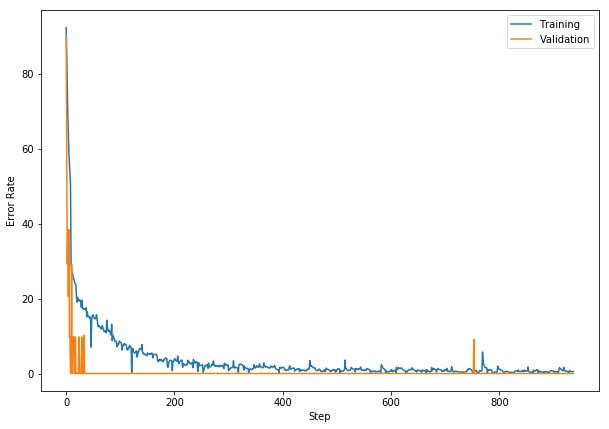

In [160]:
# 训练曲线
result1 = [100 - i['train'] for i in statistics]
result2 = [100 - i['valid'] for i in statistics]
plt.figure(figsize = (10, 7))
plt.plot(result1, label = 'Training')
plt.plot(result2, label = 'Validation')
plt.xlabel('Step')
plt.ylabel('Error Rate')
plt.legend()

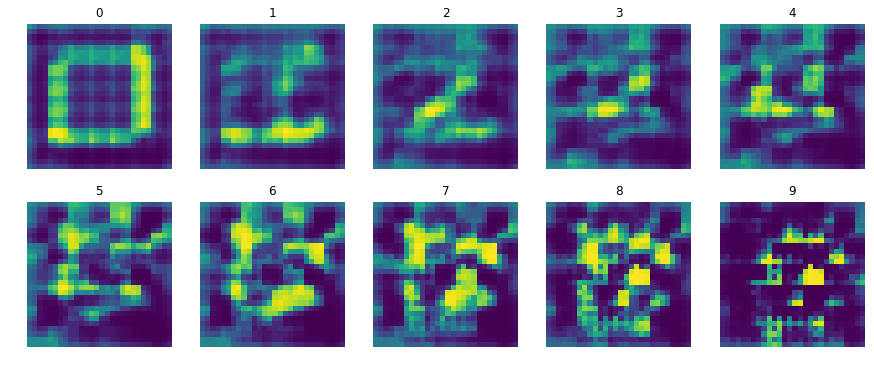

In [161]:
#绘制一批样本
samples = torch.Tensor([0,1,2,3,4,5,6,7,8,9])
samples = Variable(samples.type(dtype))

sample_size = 10
samples.data.resize_(sample_size,1,1,1)
samples = Variable(samples.data.expand(sample_size, input_dim, 1, 1))
samples = samples.cuda() if use_cuda else inputs
fake_u = netG(samples)
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
#fig = plt.figure(figsize = (15, 6))
f, axarr = plt.subplots(2,5, sharex=True, figsize=(15,6))

for i in range(sample_size):
    axarr[i // 5, i % 5].axis('off')
    imshow(img[i].data, samples.data.numpy()[i][0,0,0].astype(int), axarr[i // 5, i % 5])
    
    


Variable containing:
 9
[torch.FloatTensor of size 1x1]



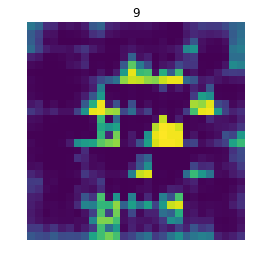

In [162]:
idx = 9
ax = plt.gca()
ax.axis('off')
imshow(fake_u[idx].data, 9, plt.gca())
print(samples[idx][0])

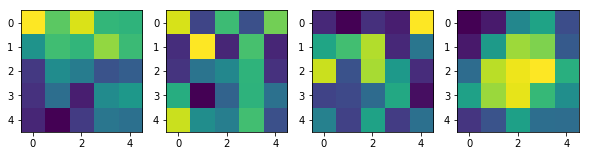

In [163]:
#提取第一层卷积层的卷积核
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    weight = netR.conv1.weight.cpu() if use_cuda else netR.conv1.weight
    plt.imshow(weight.data.numpy()[i,0,...])


### 绘制特征图

/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Variable containing:
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]



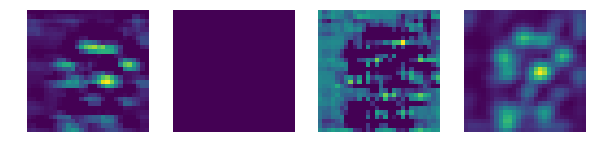

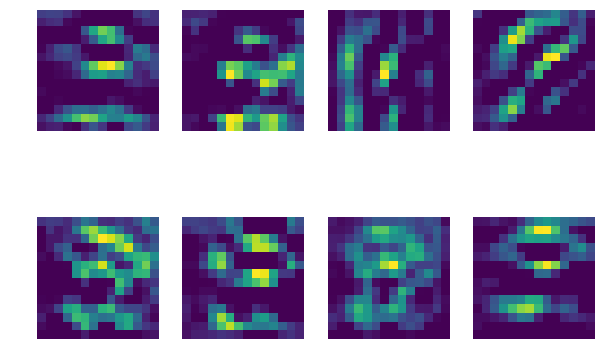

In [164]:
#调用net的retrieve_features方法可以抽取出喂入当前数据后吐出来的所有特征图（第一个卷积和第二个卷积层）

#首先定义读入的图片

#它是从test_dataset中提取第idx个批次的第0个图，其次unsqueeze的作用是在最前面添加一维，
#目的是为了让这个input_x的tensor是四维的，这样才能输入给net。补充的那一维表示batch。
input_x = fake_u[idx]
input_x = input_x.unsqueeze(0)
input_x = input_x.cuda() if use_cuda else input_x
output = netR(input_x)
_, prediction = torch.max(output, 1)
print(prediction)
feature_maps = netR.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
feature_maps = (feature_maps[0].cpu(), feature_maps[1].cpu()) if use_cuda else feature_maps
plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())
#第二层有8个特征图，循环把它们打印出来
plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i,...].data.numpy())

In [165]:
batch = next(iter(test_loader))
indx = torch.nonzero(batch[1] == 9)
data = batch[0][indx[0]]

torch.Size([1, 1, 28, 28])


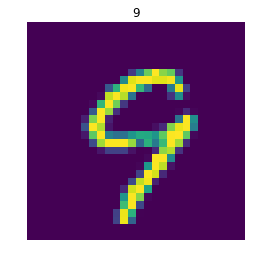

In [166]:
img = data.expand(1, 1, image_size, image_size)
print(img.size())
plt.axis('off')
imshow(img[0], 9, plt.gca())

/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Variable containing:
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]



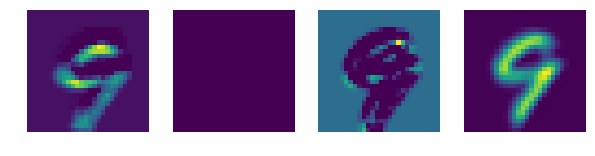

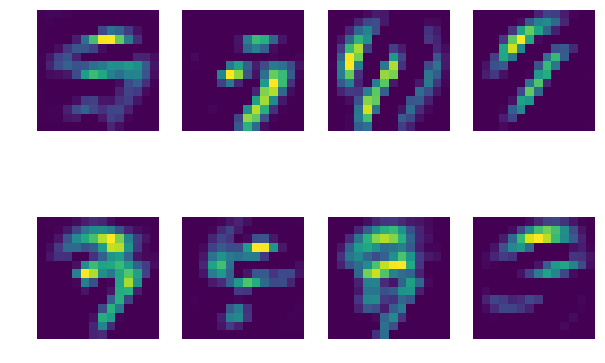

In [167]:
input_x = Variable(data)
input_x = input_x.cuda() if use_cuda else input_x
output = netR(input_x)
_, prediction = torch.max(output, 1)
print(prediction)
feature_maps = netR.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
feature_maps = (feature_maps[0].cpu(), feature_maps[1].cpu()) if use_cuda else feature_maps
plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i,...].data.numpy())

## 三、DCGAN

同样的生成器，根据输入的一个随机噪声向量生成手写数字的图像，然后再同时训练一个辨别器，它的任务就是负责辨别一张输入的图像是来源于生成器
造假还是来源于原始的数据文件。我们将两个网络一起训练。值得注意的是，辨别器和生成器的目标函数是反的。

具体训练步骤：

1、读取一个batch的原始数据，将图像喂给辨别器，辨别器应该输出为真，计算误差：D_x，

2、用随机噪声输入生成器，生成器创造一个batch的假图片，将这些图片输入给辨别器，辨别器应该输出为假，计算误差D_x2

3、将两个误差和起来，反向传播训练辨别器

4、通过生成图像计算误差，对生成器进行反向传播更新梯度

In [173]:
# 构造判别器
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD,self).__init__()
        self.model=nn.Sequential() #序列化模块构造的神经网络
        self.model.add_module('conv1',nn.Conv2d(num_channels, num_features, 5, 2, 0, bias=False)) #卷积层
        self.model.add_module('relu1',nn.ReLU()) #激活函数使用了ReLu
        #self.model.add_module('relu1',nn.LeakyReLU(0.2, inplace = True)) #激活函数使用了leakyReLu，可以防止dead ReLu的问题
        
        #第二层卷积
        self.model.add_module('conv2',nn.Conv2d(num_features, num_features * 2, 5, 2, 0, bias=False))
        self.model.add_module('bnorm2',nn.BatchNorm2d(num_features * 2)) 
        self.model.add_module('linear1', nn.Linear(num_features * 2 * 4 * 4,   #全链接网络层
                                                   num_features))
        self.model.add_module('linear2', nn.Linear(num_features, 1)) #全链接网络层
        self.model.add_module('sigmoid',nn.Sigmoid())
    def forward(self,input):
        output = input
        # 对网络中的所有神经模块进行循环，并挑选出特定的模块linear1，将feature map展平
        for name, module in self.model.named_children():
            if name == 'linear1':
                output = output.view(-1, num_features * 2 * 4 * 4)
            output = module(output)
        return output

In [174]:
# 构建一个生成器模型，并加载到GPU上
netG = ModelG().cuda() if use_cuda else ModelG()
# 初始化网络的权重
netG.apply(weight_init)
print(netG)

# 构建一个辨别器网络，并加载的GPU上
netD=ModelD().cuda() if use_cuda else ModelD()
# 初始化权重
netD.apply(weight_init)

# 要优化两个网络，所以需要有两个优化器
# 使用Adam优化器，可以自动调节收敛速度
#optimizerD=optim.SGD(netD.parameters(),lr=0.0002)
#optimizerG=optim.SGD(netG.parameters(),lr=0.0002)
optimizerD=optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizerG=optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))


# 模型的输入输出
# 生成一个随机噪声输入给生成器
noise=Variable(torch.FloatTensor(batch_size, input_dim, 1, 1))
#固定噪声是用于评估生成器结果的，它在训练过程中始终不变
fixed_noise=Variable(torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1))
if use_cuda:
    noise = noise.cuda()
    fixed_noise = fixed_noise.cuda()


#BCE损失函数
criterion=nn.BCELoss()
error_G = None #总误差
num_epochs = 100 #训练周期
results = []
for epoch in range(num_epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        #训练辨别器网络
        #清空梯度
        optimizerD.zero_grad()
        #1、输入真实图片
        data, target = Variable(data), Variable(target)
        # 用于鉴别赝品还是真品的标签
        label = Variable(torch.ones(data.size()[0]))  #正确的标签是1（真实）
        label = label.cuda() if use_cuda else label
        
        if use_cuda:
            data, target, label = data.cuda(), target.cuda(), label.cuda()
        netD.train()
        output=netD(data) #放到辨别网络里辨别

        
        #计算损失函数
        label.data.fill_(1)
        error_real=criterion(output, label)
        error_real.backward() #辨别器的反向误差传播
        D_x=output.data.mean()
        
        #2、用噪声生成一张假图片
        noise.data.resize_(data.size()[0], input_dim, 1, 1).normal_(0, 1) #噪声是一个input_dim维度的向量
        #喂给生成器生成图像
        fake_pic=netG(noise).detach() #这里的detach是为了让生成器不参与梯度更新
        output2=netD(fake_pic) #用辨别器识别假图像
        label.data.fill_(0) #正确的标签应该是0（伪造）
        error_fake=criterion(output2,label) #计算损失函数
        error_fake.backward() #反向传播误差
        error_D=error_real + error_fake #计算真实图像和机器生成图像的总误差
        optimizerD.step() #开始优化
        # 单独训练生成器网络
        if error_G is None or np.random.rand() < 0.5:
            optimizerG.zero_grad() #清空生成器梯度

            '''注意生成器的目标函数是与辨别器的相反的，故而当辨别器无法辨别的时候为正确'''
            label.data.fill_(1) #分类标签全部标为1，即真实图像
            noise.data.normal_(0,1) #重新随机生成一个噪声向量
            netG.train()
            fake_pic=netG(noise) #生成器生成一张伪造图像
            output=netD(fake_pic) #辨别器进行分辨
            error_G=criterion(output,label) #辨别器的损失函数
            error_G.backward() #反向传播
            optimizerG.step() #优化网络
        if use_cuda:
            error_D = error_D.cpu()
            error_G = error_G.cpu()
        # 记录数据
        results.append([float(error_D.data.numpy()), float(error_G.data.numpy())])
        
        # 打印分类器损失等指标
        if batch_idx % 100 == 0:
            print ('第{}周期，第{}/{}撮, 分类器Loss:{:.2f}, 生成器Loss:{:.2f}'.format(
                epoch,batch_idx,len(train_loader), error_D.data[0], error_G.data[0]))
    #生成一些随机图片，但因输出到文件
    netG.eval()
    fake_u=netG(fixed_noise)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)

    #挑选一些真实数据中的图像图像保存
    data, _ = next(iter(train_loader))
    vutil.save_image(img,'temp/fake%s.png'% (epoch))
    # 保存网络状态到硬盘文件
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('net', epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('net', epoch))
    if epoch == 0:
        img = make_show(Variable(data))
        vutil.save_image(img,'temp/real%s.png' % (epoch))

ModelG(
  (model): Sequential(
    (deconv1): ConvTranspose2d (100, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (relu1): ReLU(inplace)
    (deconv2): ConvTranspose2d (128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU(inplace)
    (deconv3): ConvTranspose2d (64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (sigmoid): Sigmoid()
  )
)
第0周期，第0/938撮, 分类器Loss:1.36, 生成器Loss:0.77


/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


第0周期，第100/938撮, 分类器Loss:0.65, 生成器Loss:3.76
第0周期，第200/938撮, 分类器Loss:0.27, 生成器Loss:4.34
第0周期，第300/938撮, 分类器Loss:0.06, 生成器Loss:5.29
第0周期，第400/938撮, 分类器Loss:0.13, 生成器Loss:3.90
第0周期，第500/938撮, 分类器Loss:0.00, 生成器Loss:6.89
第0周期，第600/938撮, 分类器Loss:0.00, 生成器Loss:6.72
第0周期，第700/938撮, 分类器Loss:0.00, 生成器Loss:6.26
第0周期，第800/938撮, 分类器Loss:0.01, 生成器Loss:5.61
第0周期，第900/938撮, 分类器Loss:0.01, 生成器Loss:6.15


/home/boss/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


第1周期，第0/938撮, 分类器Loss:0.01, 生成器Loss:5.85
第1周期，第100/938撮, 分类器Loss:0.00, 生成器Loss:7.37
第1周期，第200/938撮, 分类器Loss:0.00, 生成器Loss:7.68
第1周期，第300/938撮, 分类器Loss:0.00, 生成器Loss:6.72
第1周期，第400/938撮, 分类器Loss:0.00, 生成器Loss:6.69
第1周期，第500/938撮, 分类器Loss:0.00, 生成器Loss:7.83
第1周期，第600/938撮, 分类器Loss:0.00, 生成器Loss:8.23
第1周期，第700/938撮, 分类器Loss:0.00, 生成器Loss:8.43
第1周期，第800/938撮, 分类器Loss:0.00, 生成器Loss:7.73
第1周期，第900/938撮, 分类器Loss:0.00, 生成器Loss:8.19
第2周期，第0/938撮, 分类器Loss:0.00, 生成器Loss:8.56
第2周期，第100/938撮, 分类器Loss:0.00, 生成器Loss:8.72
第2周期，第200/938撮, 分类器Loss:0.00, 生成器Loss:8.14
第2周期，第300/938撮, 分类器Loss:0.00, 生成器Loss:8.89
第2周期，第400/938撮, 分类器Loss:0.00, 生成器Loss:8.29
第2周期，第500/938撮, 分类器Loss:0.00, 生成器Loss:8.60
第2周期，第600/938撮, 分类器Loss:0.00, 生成器Loss:8.32
第2周期，第700/938撮, 分类器Loss:0.00, 生成器Loss:8.74
第2周期，第800/938撮, 分类器Loss:0.00, 生成器Loss:8.42
第2周期，第900/938撮, 分类器Loss:0.00, 生成器Loss:9.08
第3周期，第0/938撮, 分类器Loss:0.00, 生成器Loss:9.03
第3周期，第100/938撮, 分类器Loss:0.00, 生成器Loss:9.35
第3周期，第200/938撮, 分类器Loss:0.00, 生成器Loss:8.71
第3周期，第300/938撮, 分

第20周期，第0/938撮, 分类器Loss:1.07, 生成器Loss:6.58
第20周期，第100/938撮, 分类器Loss:0.30, 生成器Loss:3.70
第20周期，第200/938撮, 分类器Loss:1.02, 生成器Loss:4.39
第20周期，第300/938撮, 分类器Loss:0.04, 生成器Loss:5.35
第20周期，第400/938撮, 分类器Loss:0.06, 生成器Loss:4.29
第20周期，第500/938撮, 分类器Loss:0.04, 生成器Loss:8.48
第20周期，第600/938撮, 分类器Loss:0.10, 生成器Loss:6.61
第20周期，第700/938撮, 分类器Loss:0.08, 生成器Loss:4.74
第20周期，第800/938撮, 分类器Loss:0.82, 生成器Loss:2.76
第20周期，第900/938撮, 分类器Loss:0.15, 生成器Loss:7.00
第21周期，第0/938撮, 分类器Loss:0.11, 生成器Loss:3.92
第21周期，第100/938撮, 分类器Loss:0.10, 生成器Loss:4.99
第21周期，第200/938撮, 分类器Loss:0.33, 生成器Loss:3.50
第21周期，第300/938撮, 分类器Loss:0.05, 生成器Loss:5.07
第21周期，第400/938撮, 分类器Loss:0.07, 生成器Loss:5.98
第21周期，第500/938撮, 分类器Loss:0.07, 生成器Loss:6.42
第21周期，第600/938撮, 分类器Loss:0.02, 生成器Loss:9.62
第21周期，第700/938撮, 分类器Loss:0.05, 生成器Loss:6.29
第21周期，第800/938撮, 分类器Loss:0.02, 生成器Loss:7.42
第21周期，第900/938撮, 分类器Loss:0.03, 生成器Loss:4.10
第22周期，第0/938撮, 分类器Loss:0.14, 生成器Loss:4.37
第22周期，第100/938撮, 分类器Loss:0.13, 生成器Loss:4.23
第22周期，第200/938撮, 分类器Loss:0.09, 生成器Loss

第38周期，第800/938撮, 分类器Loss:0.12, 生成器Loss:6.63
第38周期，第900/938撮, 分类器Loss:0.03, 生成器Loss:5.94
第39周期，第0/938撮, 分类器Loss:0.28, 生成器Loss:8.35
第39周期，第100/938撮, 分类器Loss:0.21, 生成器Loss:11.22
第39周期，第200/938撮, 分类器Loss:0.02, 生成器Loss:6.71
第39周期，第300/938撮, 分类器Loss:0.02, 生成器Loss:8.00
第39周期，第400/938撮, 分类器Loss:0.08, 生成器Loss:7.93
第39周期，第500/938撮, 分类器Loss:0.09, 生成器Loss:7.15
第39周期，第600/938撮, 分类器Loss:0.10, 生成器Loss:8.02
第39周期，第700/938撮, 分类器Loss:0.02, 生成器Loss:3.80
第39周期，第800/938撮, 分类器Loss:0.19, 生成器Loss:7.62
第39周期，第900/938撮, 分类器Loss:0.16, 生成器Loss:4.81
第40周期，第0/938撮, 分类器Loss:0.07, 生成器Loss:7.27
第40周期，第100/938撮, 分类器Loss:0.10, 生成器Loss:7.21
第40周期，第200/938撮, 分类器Loss:0.03, 生成器Loss:4.99
第40周期，第300/938撮, 分类器Loss:0.01, 生成器Loss:5.16
第40周期，第400/938撮, 分类器Loss:0.04, 生成器Loss:8.08
第40周期，第500/938撮, 分类器Loss:0.50, 生成器Loss:6.99
第40周期，第600/938撮, 分类器Loss:0.26, 生成器Loss:4.87
第40周期，第700/938撮, 分类器Loss:0.05, 生成器Loss:7.72
第40周期，第800/938撮, 分类器Loss:0.04, 生成器Loss:4.00
第40周期，第900/938撮, 分类器Loss:0.06, 生成器Loss:3.71
第41周期，第0/938撮, 分类器Loss:0.16, 生成器Los

第57周期，第500/938撮, 分类器Loss:0.34, 生成器Loss:6.91
第57周期，第600/938撮, 分类器Loss:0.06, 生成器Loss:5.94
第57周期，第700/938撮, 分类器Loss:0.64, 生成器Loss:6.35
第57周期，第800/938撮, 分类器Loss:0.06, 生成器Loss:4.82
第57周期，第900/938撮, 分类器Loss:0.09, 生成器Loss:4.05
第58周期，第0/938撮, 分类器Loss:0.10, 生成器Loss:2.11
第58周期，第100/938撮, 分类器Loss:0.08, 生成器Loss:4.06
第58周期，第200/938撮, 分类器Loss:0.02, 生成器Loss:6.86
第58周期，第300/938撮, 分类器Loss:0.08, 生成器Loss:8.81
第58周期，第400/938撮, 分类器Loss:0.19, 生成器Loss:4.92
第58周期，第500/938撮, 分类器Loss:0.01, 生成器Loss:5.14
第58周期，第600/938撮, 分类器Loss:0.04, 生成器Loss:5.87
第58周期，第700/938撮, 分类器Loss:0.08, 生成器Loss:6.16
第58周期，第800/938撮, 分类器Loss:0.08, 生成器Loss:6.01
第58周期，第900/938撮, 分类器Loss:0.10, 生成器Loss:4.33
第59周期，第0/938撮, 分类器Loss:0.12, 生成器Loss:7.45
第59周期，第100/938撮, 分类器Loss:0.08, 生成器Loss:5.96
第59周期，第200/938撮, 分类器Loss:0.06, 生成器Loss:6.18
第59周期，第300/938撮, 分类器Loss:0.17, 生成器Loss:8.23
第59周期，第400/938撮, 分类器Loss:0.19, 生成器Loss:7.88
第59周期，第500/938撮, 分类器Loss:0.14, 生成器Loss:4.06
第59周期，第600/938撮, 分类器Loss:0.04, 生成器Loss:4.03
第59周期，第700/938撮, 分类器Loss:0.17, 生成器Lo

第76周期，第200/938撮, 分类器Loss:0.21, 生成器Loss:7.33
第76周期，第300/938撮, 分类器Loss:0.04, 生成器Loss:10.77
第76周期，第400/938撮, 分类器Loss:0.01, 生成器Loss:3.09
第76周期，第500/938撮, 分类器Loss:0.04, 生成器Loss:8.31
第76周期，第600/938撮, 分类器Loss:0.94, 生成器Loss:4.24
第76周期，第700/938撮, 分类器Loss:0.15, 生成器Loss:3.50
第76周期，第800/938撮, 分类器Loss:0.14, 生成器Loss:6.02
第76周期，第900/938撮, 分类器Loss:0.06, 生成器Loss:4.24
第77周期，第0/938撮, 分类器Loss:0.19, 生成器Loss:9.37
第77周期，第100/938撮, 分类器Loss:0.03, 生成器Loss:3.06
第77周期，第200/938撮, 分类器Loss:0.00, 生成器Loss:4.37
第77周期，第300/938撮, 分类器Loss:0.07, 生成器Loss:4.45
第77周期，第400/938撮, 分类器Loss:0.05, 生成器Loss:5.24
第77周期，第500/938撮, 分类器Loss:0.69, 生成器Loss:3.88
第77周期，第600/938撮, 分类器Loss:0.24, 生成器Loss:3.79
第77周期，第700/938撮, 分类器Loss:0.00, 生成器Loss:7.95
第77周期，第800/938撮, 分类器Loss:0.05, 生成器Loss:4.10
第77周期，第900/938撮, 分类器Loss:0.02, 生成器Loss:6.76
第78周期，第0/938撮, 分类器Loss:0.17, 生成器Loss:10.06
第78周期，第100/938撮, 分类器Loss:0.04, 生成器Loss:7.48
第78周期，第200/938撮, 分类器Loss:0.18, 生成器Loss:5.92
第78周期，第300/938撮, 分类器Loss:0.16, 生成器Loss:4.83
第78周期，第400/938撮, 分类器Loss:0.31, 生成器

第94周期，第900/938撮, 分类器Loss:0.07, 生成器Loss:7.52
第95周期，第0/938撮, 分类器Loss:0.16, 生成器Loss:7.97
第95周期，第100/938撮, 分类器Loss:0.01, 生成器Loss:9.34
第95周期，第200/938撮, 分类器Loss:0.28, 生成器Loss:7.22
第95周期，第300/938撮, 分类器Loss:0.02, 生成器Loss:6.04
第95周期，第400/938撮, 分类器Loss:0.05, 生成器Loss:6.37
第95周期，第500/938撮, 分类器Loss:0.03, 生成器Loss:8.91
第95周期，第600/938撮, 分类器Loss:0.15, 生成器Loss:2.82
第95周期，第700/938撮, 分类器Loss:0.36, 生成器Loss:4.73
第95周期，第800/938撮, 分类器Loss:0.02, 生成器Loss:6.27
第95周期，第900/938撮, 分类器Loss:0.00, 生成器Loss:6.34
第96周期，第0/938撮, 分类器Loss:2.27, 生成器Loss:1.25
第96周期，第100/938撮, 分类器Loss:0.03, 生成器Loss:4.72
第96周期，第200/938撮, 分类器Loss:0.18, 生成器Loss:8.48
第96周期，第300/938撮, 分类器Loss:0.27, 生成器Loss:2.47
第96周期，第400/938撮, 分类器Loss:0.04, 生成器Loss:6.09
第96周期，第500/938撮, 分类器Loss:0.05, 生成器Loss:6.19
第96周期，第600/938撮, 分类器Loss:0.01, 生成器Loss:7.49
第96周期，第700/938撮, 分类器Loss:0.06, 生成器Loss:2.87
第96周期，第800/938撮, 分类器Loss:0.08, 生成器Loss:7.12
第96周期，第900/938撮, 分类器Loss:0.01, 生成器Loss:7.87
第97周期，第0/938撮, 分类器Loss:0.05, 生成器Loss:6.82
第97周期，第100/938撮, 分类器Loss:0.36, 生成器Loss

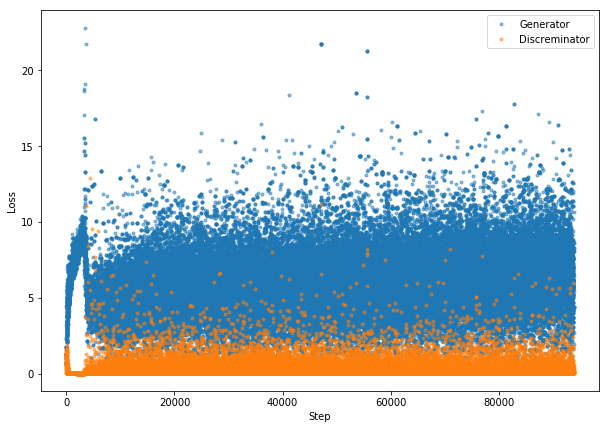

In [175]:
# 预测曲线
plt.figure(figsize = (10, 7))
plt.plot([i[1] for i in results], '.', label = 'Generator', alpha = 0.5)
plt.plot([i[0] for i in results], '.', label = 'Discreminator', alpha = 0.5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

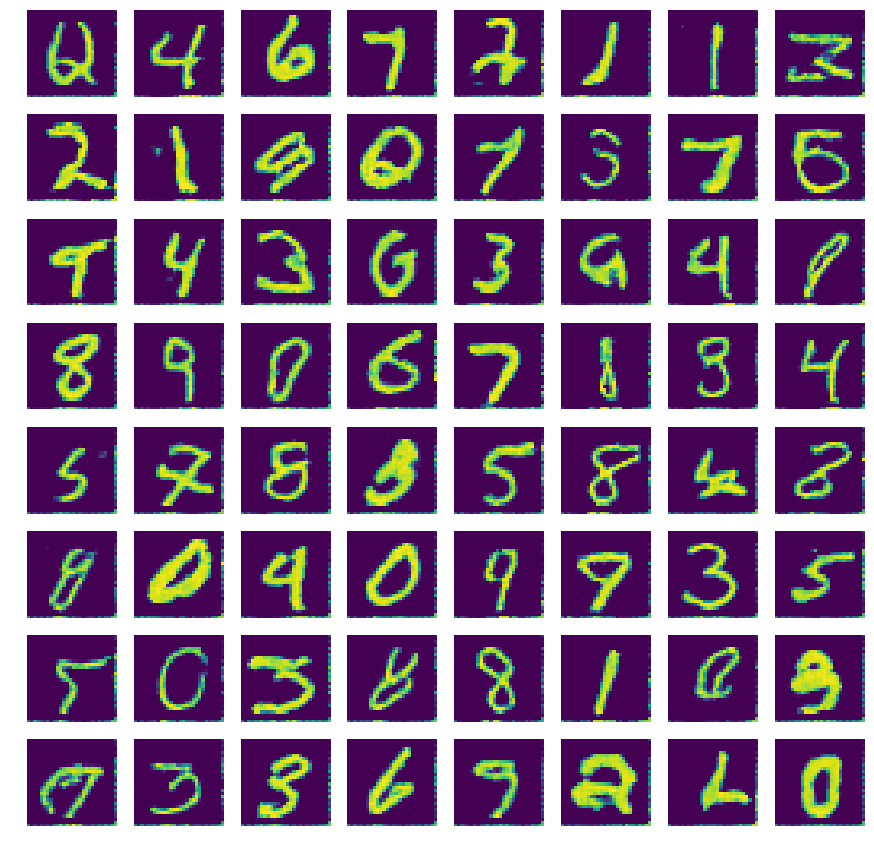

In [176]:
# 绘制一些样本
noise = Variable(torch.FloatTensor(batch_size, input_dim, 1, 1))
noise.data.normal_(0,1)
noise = noise.cuda() if use_cuda else noise
sample_size = batch_size
netG.eval()
fake_u = netG(noise)
fake_u = fake_u.cpu() if use_cuda else fake_u
noise = noise.cpu() if use_cuda else samples
img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
#print(img.size())
f, axarr = plt.subplots(8,8, sharex=True, figsize=(15,15))
for i in range(batch_size):
    axarr[i // 8, i % 8].axis('off')
    imshow(img[i].data, None,axarr[i // 8, i % 8])